### Homework 2: Uncertainty and Vision
CS-229 Spring 2023

The goal of this assignment is to get familiar with training a computer vision task (Segmentation) with PyTorch, and to measure confidence calibration in your system. 

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def plot_tensor_image(tensor):
    # Convert tensor to numpy array and reshape if necessary
    if len(tensor.shape) == 4:
        tensor = tensor.squeeze(0)
    array = tensor.numpy().transpose((1, 2, 0))
    
    # Rescale values to range [0, 1]
    array = (array - array.min()) / (array.max() - array.min())
    
    # Plot the image using Matplotlib
    plt.imshow(array)
    plt.axis('off')
    plt.show()

In [ ]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

In [ ]:
def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # TODO: 2 points. Define image transforms for both the input image AND the "label" image.
    # Remember, the labels are one category (integer) per pixel. So, while the image_transform
    # normalize the values to have mean zero and unit standard deviation, you shouldn't 
    # do that with the labels, which have to be integers. I provided a "ToIntTensor" transform
    # above to use for the label transform, instead of ToTensor which always turns images to floats. 
    # Also, we want to resize/crop images to be all the same size, a power of 2, and 
    # we should transform the label and image in the same way when changing size.
    # The size of images will drastically impact memory usage - I suggest targeting 128 x 128 
    # or even 64 x 64 if memory constraints are an issue. 


    #transformation for  train_dataset 
    image_transforms = transforms.Compose([
       transforms.Resize((128, 128)),
       transforms.RandomCrop((128, 128)),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    #transformation for  validation dataset
    label_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomCrop((128, 128)),
        transforms.RandomHorizontalFlip(),
        ToIntTensor(),
    ])



    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "./"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform = label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform = label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl
    
    

In [ ]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    # We'll use the cross entropy loss. There's a nice feature that it
    # allows you to "ignore_index". In this case index 255 is the mask to ignore
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # Set model to train mode
    model.train()

    train_loss = 0.0
    for inputs, labels in train_dl:

        #Move inputs and labels to the device  
        inputs, labels = inputs.to(device), labels.to(device)
        
        #pervious dw = 0
        optimizer.zero_grad()


        #squeezing labesls from 4d to 3d
        labels = labels.squeeze(1)

       
        #foward pass throught the model and getting tensor matrix from the dictionary
        outputs = model(inputs)['out']

      
        # mask = outputs.argmax(1).squeeze(0)


        # prob = outputs.softmax(1).squeeze(0)

        # print(labels.shape)


        #calculating loss
        loss = criterion(outputs , labels)

       


        # print(loss)
        
        #backward propagation
        loss.backward()

       
        # changing the model parameters
        optimizer.step()


        #calculating loss  
        train_loss += loss.item()

        # print(train_loss)

    # # Calculate the average training loss for this epoch
    num_batches = len(train_dl)
    train_loss /= num_batches

    # Set model to evaluation mode
    model.eval()

    # Turn off gradient tracking for validation
    with torch.no_grad():
        val_loss = 0.0
        total_pixels = 0
        correct_pixels = 0
        for inputs, labels in val_dl:

            # Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)


            # Forward pass through the model
            outputs = model(inputs)
             

            #getting tensor matrix from the dictionary
            pred_classes = outputs['out']

            


            #squeezing labesls from 4d to 3d
            labels = labels.squeeze(1)

            #calculating loss
            loss = criterion(pred_classes, labels)

            # Update the total validation loss
            val_loss += loss.item()

           

            #getting predicted labels of the pixels
            predicted = pred_classes.argmax(1)


            


            #total pixels in the batch
            total_pixels += labels.numel()
            
            #correct pixels predicted
            correct_pixels += (predicted == labels).sum().item()

        # Calculate the average validation loss for this epoch
        val_loss /= len(val_dl)

        # Calculate the validation accuracy for this epoch
        accuracy = correct_pixels / total_pixels

    # Set model back to train mode
    model.train()

    return train_loss, val_loss, accuracy
    return train_loss

### Main loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.05
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# # Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.2MB/s]


100%|██████████| 460032000/460032000 [00:32<00:00, 14139863.86it/s]


Extracting ./VOCtrainval_06-Nov-2007.tar to ./
Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./


In [ ]:

train_losses, val_losses = [], []

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0, weight_decay=0.0004)

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # ????

for epoch in range(epochs):

    train_loss, val_loss, accuracy =   train_epoch(model, train_dl, val_dl, optimizer, device)
   
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))

Epoch 1: Train loss: 1.912 | Val loss: 1.432 | Acc: 0.711
Epoch 2: Train loss: 0.861 | Val loss: 1.241 | Acc: 0.726
Epoch 3: Train loss: 0.692 | Val loss: 1.192 | Acc: 0.734
Epoch 4: Train loss: 0.657 | Val loss: 0.979 | Acc: 0.733
Epoch 5: Train loss: 0.593 | Val loss: 0.834 | Acc: 0.738
Epoch 6: Train loss: 0.556 | Val loss: 0.817 | Acc: 0.748
Epoch 7: Train loss: 0.517 | Val loss: 0.777 | Acc: 0.744
Epoch 8: Train loss: 0.530 | Val loss: 0.785 | Acc: 0.741
Epoch 9: Train loss: 0.494 | Val loss: 0.764 | Acc: 0.750
Epoch 10: Train loss: 0.490 | Val loss: 0.803 | Acc: 0.740
Epoch 11: Train loss: 0.453 | Val loss: 0.771 | Acc: 0.746
Epoch 12: Train loss: 0.432 | Val loss: 0.753 | Acc: 0.752
Epoch 13: Train loss: 0.437 | Val loss: 0.758 | Acc: 0.746
Epoch 14: Train loss: 0.445 | Val loss: 0.815 | Acc: 0.744
Epoch 15: Train loss: 0.414 | Val loss: 0.792 | Acc: 0.745
Epoch 16: Train loss: 0.388 | Val loss: 0.780 | Acc: 0.748
Epoch 17: Train loss: 0.423 | Val loss: 0.762 | Acc: 0.744
Epoch 

## Post training visualization and analysis

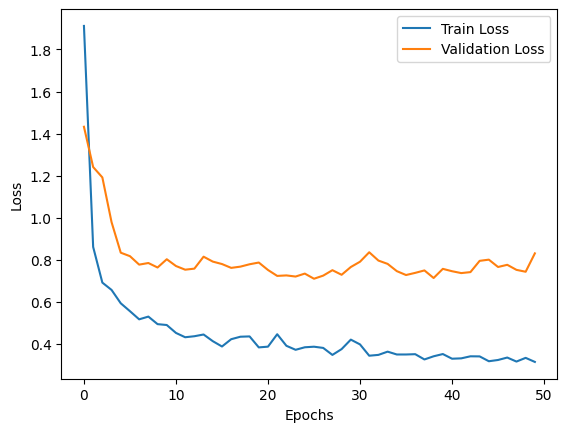

In [ ]:
# TODO: Train and test loss plot

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<ipython-input-9-80c53610c384>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', 21)


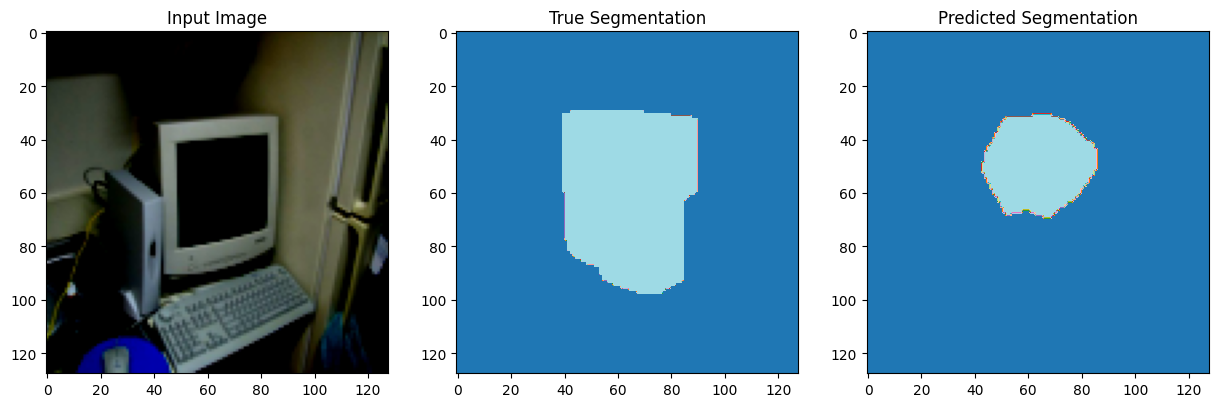

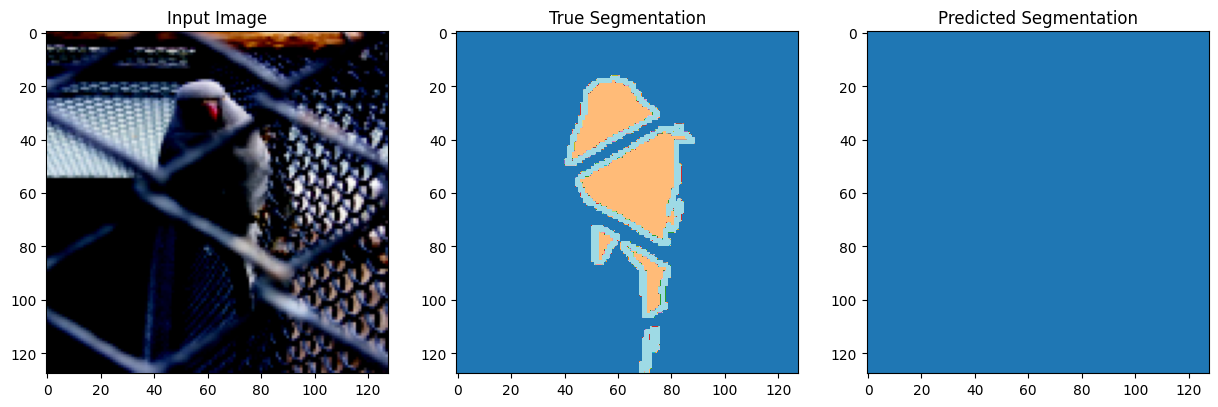

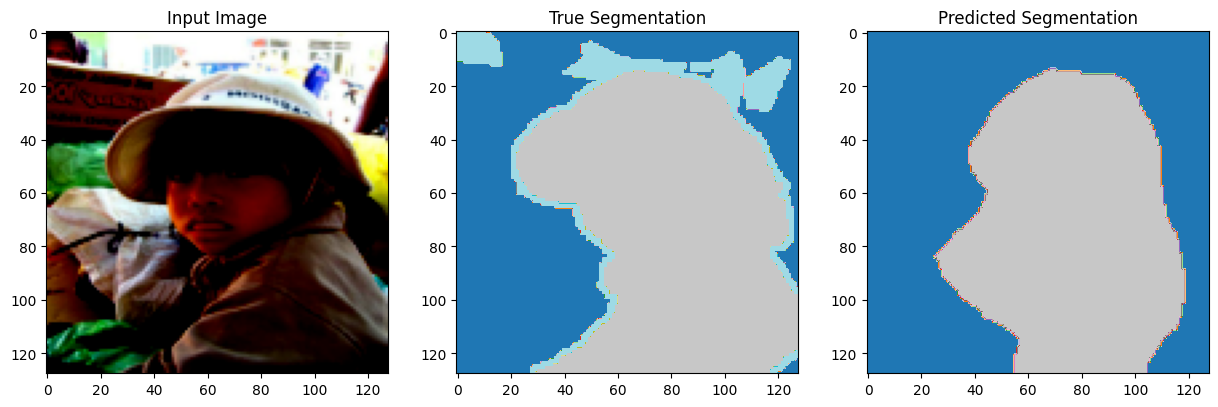

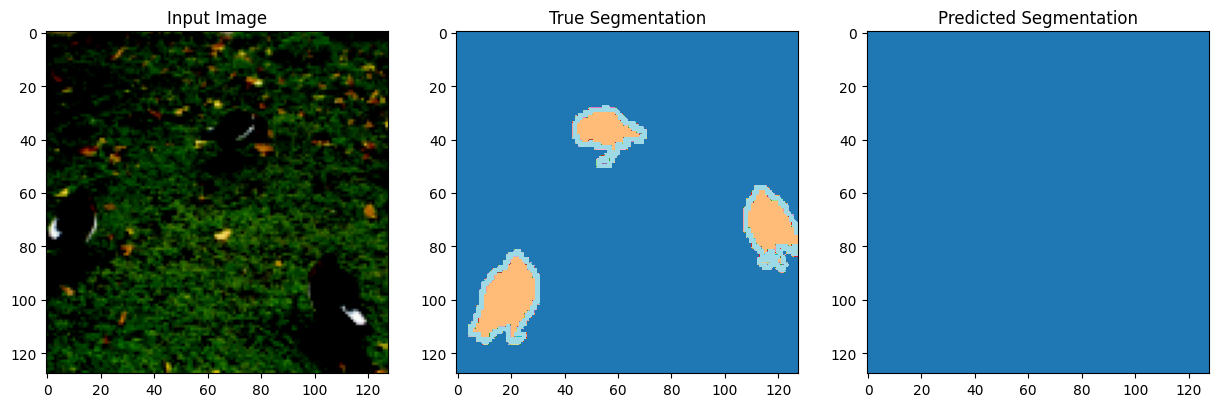

In [ ]:
# TODO: Print out an example image, true segmentation, and predicted segmentation
# 1 point
# Use a colormap to get good visualizations of the segmentation classes
# cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
# cmap(numpy class array) outputs something with nice colors
i = 0
model.eval()
with torch.no_grad():
  for inputs, labels in val_dl:
    if i == 10:
      break
    i += 1
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    preds = torch.argmax(outputs['out'], dim=1)
    inputs = inputs.cpu().numpy().transpose((0, 2, 3, 1))
    labels = labels.cpu().numpy().squeeze(1)
    preds = preds.cpu().numpy()

    # Get a colormap with 21 distinct colors
    cmap = plt.cm.get_cmap('tab20', 21)

    # Plot example image, label and prediction
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(inputs[0])
    ax[0].set_title("Input Image")
    ax[1].imshow(labels[0], cmap=cmap, vmin=0, vmax=20)
    ax[1].set_title("True Segmentation")
    ax[2].imshow(preds[0], cmap=cmap, vmin=0, vmax=20)
    ax[2].set_title("Predicted Segmentation")
    plt.show()

In [ ]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1) # batch, h, w  - integer values 0..20 or 255 for mask

        # print(labels.shape)
          
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        
        # print(probs.shape)

        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label

        # print( confidence.shape)

        # print(confidence[0][0])

        accuracy = (predicted_label == labels)

        accuracy_filter = accuracy[labels < 255]

        confidence_filter = confidence[labels < 255]

        all_acc.append(accuracy_filter)

        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        


In [ ]:
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]

bin_centers = 0.5*(bin_lowers+bin_uppers)

bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin


for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

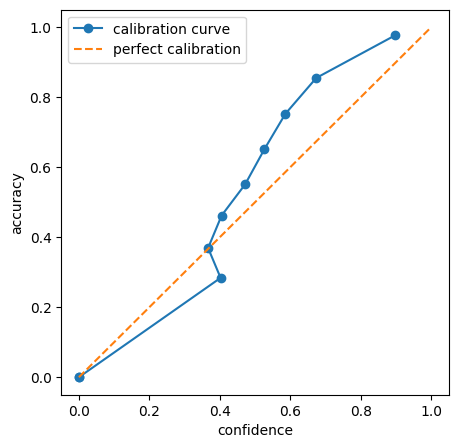

In [ ]:
# # TODO: Plot confidence calibration curve 

plt.figure(figsize=(5,5))
plt.plot(bin_acc, bin_conf, 'o-', label='calibration curve') 
plt.plot([0, 1], [0, 1], '--', label='perfect calibration')  
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.legend()





In [ ]:
# # TODO: calculate expected calibration error (1 point), using 
ece = np.sum(bin_frac * np.abs(bin_acc - bin_conf))
print("ECE: ", ece)

ECE:  0.09954710518293361


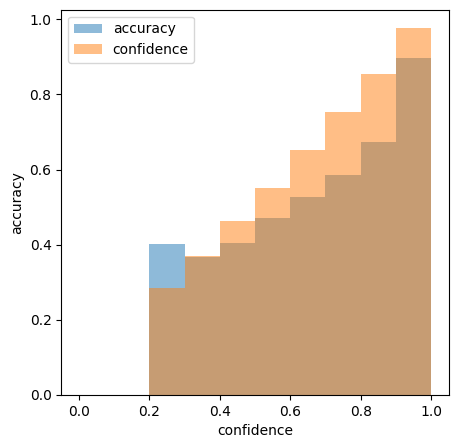

In [ ]:
# # TODO: confidence versus accuracy bar chart
plt.figure(figsize=(5,5))
plt.bar(bin_centers, bin_acc, width=0.1, align='center', label='accuracy', alpha=0.5)
plt.bar(bin_centers, bin_conf, width=0.1, align='center', label='confidence', alpha=0.5)
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.legend()